In [19]:


import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def medfilt (x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median (y, axis=1)

def parse_data(base):
    queue_path = base + '_queues.csv'
    data_path = base + '_image_data.csv'
    with open(queue_path, 'r') as f:
        data = list(csv.reader(f, delimiter="\n"))
    _, circ_buffer_max, acq_queue_max, writing_queue_max = data[0][0].split(',')
    circ_buffer_max, acq_queue_max, writing_queue_max = int(circ_buffer_max), int(acq_queue_max), int(writing_queue_max)
    array = np.array([[int(s) for s in line[0].split(',')] for line in data[1:]])
    time_ms, buffer_mem, acq_queue, writing_queue = array.T
    
    with open(data_path, 'r') as f:
        data = list(csv.reader(f, delimiter="\n"))
    array = np.array([[int(s) for s in line[0].split(',')] for line in data])
    image_time_ms, bytes_written = array.T
    image_time_ms = image_time_ms - image_time_ms[0]
    
    return circ_buffer_max, acq_queue_max, writing_queue_max, time_ms, \
            buffer_mem, acq_queue, writing_queue, image_time_ms, bytes_written
   
def make_queue_and_data_plots(circ_buffer_max, acq_queue_max, writing_queue_max,
               time_ms, buffer_mem, acq_queue, writing_queue, image_times_ms, bytes_written,
                             smooth_rate_sigma=1, time_limits=None):
    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(6, 8))
    for index, (values, max_value, label, ylabel) in \
            enumerate([(buffer_mem, circ_buffer_max, 'circular buffer', '# images'),
                    (acq_queue, acq_queue_max, 'AcqEng output queue', '# images'),
                    (writing_queue, writing_queue_max, 'Writing task queue', '# images'),]):
        ax[index].plot(time_ms /1000, values, '.')
        ax[index].legend([label])
        ax[index].axhline(max_value,  linestyle='--', color='k')
        ax[index].set_ylim([0, max_value *1.1])
        ax[index].set_xlim([0, time_ms[-1] / 1000])
        ax[index].set_ylabel(ylabel)
    # data plots
    ax[3].plot(image_times_ms / 1000., bytes_written / 1024. / 1024. / 1024., '.r')
    ax[3].set_xlabel('time (s)')
    ax[3].set_ylabel('GB image data written')
    
    # compute write speed
    times_s = image_times_ms / 1000.
    written_GB = bytes_written / 1024. / 1024. / 1024.
    # Remove ends which have weird values
    times_s = times_s[1:-1]
    written_GB = written_GB[1:-1]
    
    rate = (written_GB[1:] - written_GB[:-1]) / (times_s[1:] - times_s[:-1] + 1e-5)
    
    # rate = medfilt(rate, 3)
    
    plot_time = times_s[1:]
    plot_rate = rate
    
    # gaussian filter to get better view
    plot_rate = gaussian_filter1d(plot_rate, smooth_rate_sigma)
    
    ax[4].plot(plot_time, plot_rate, '.r')
    ax[4].set_xlabel('time (s)')
    ax[4].set_ylabel('GB / s')
    ax[4].set_ylim([0, 1.1 * np.percentile(plot_rate, 90)])
    
    if time_limits is not None:
        ax[4].set_xlim(time_limits)
    return plot_rate

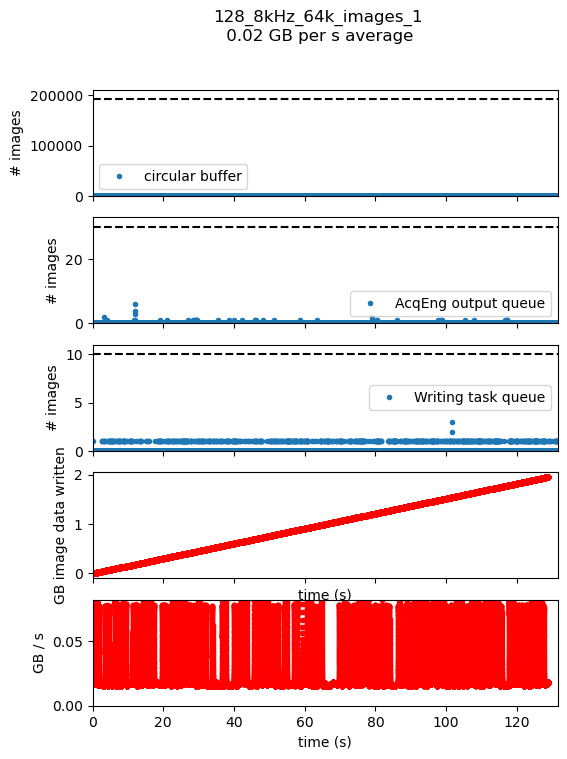

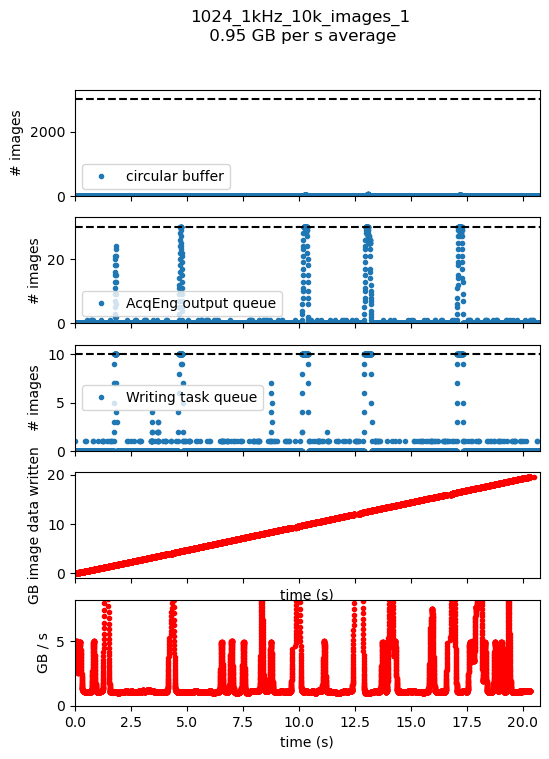

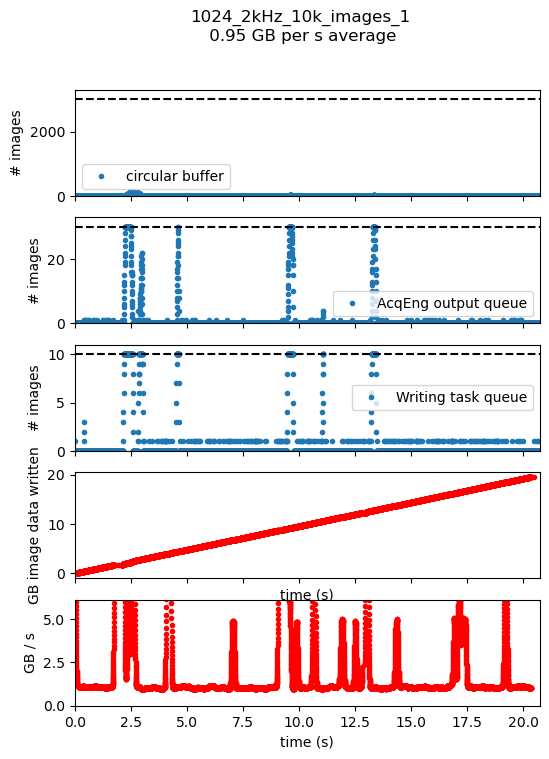

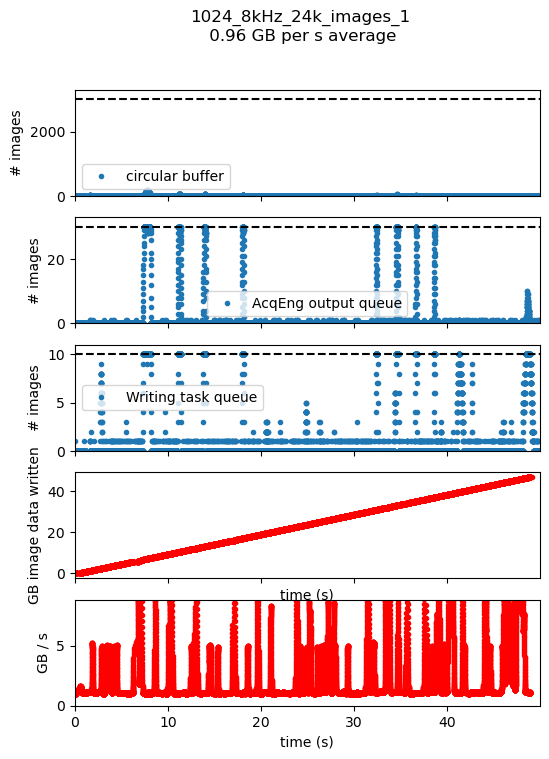

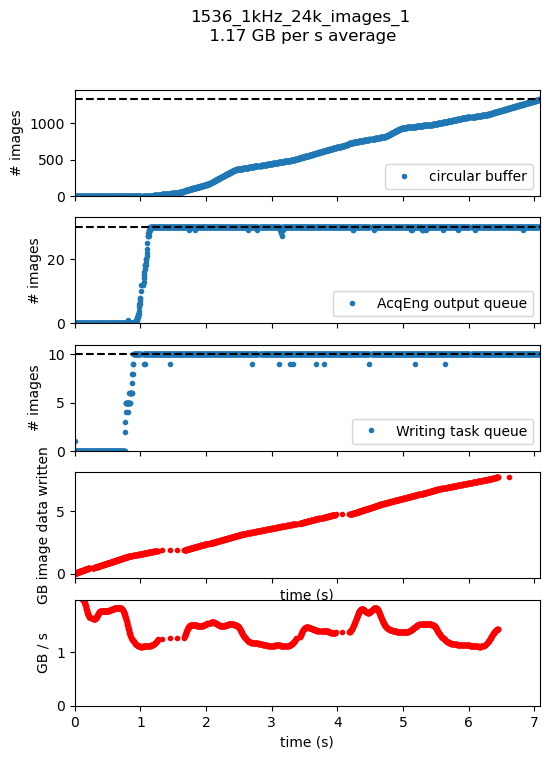

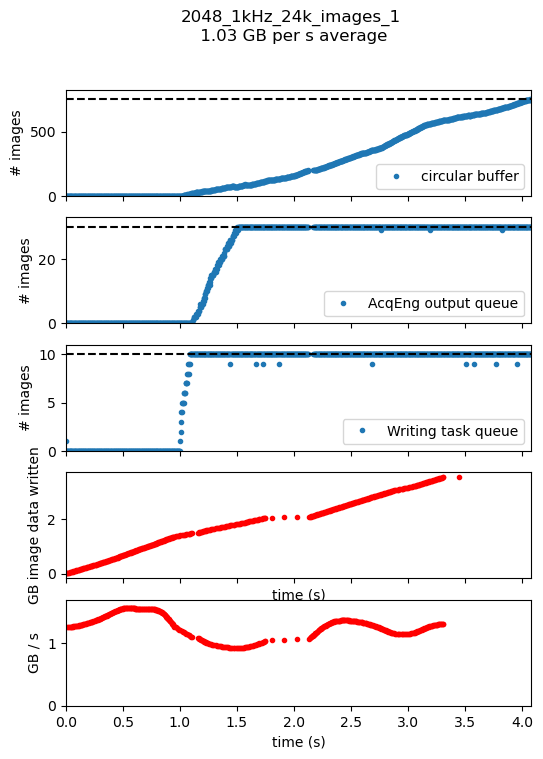

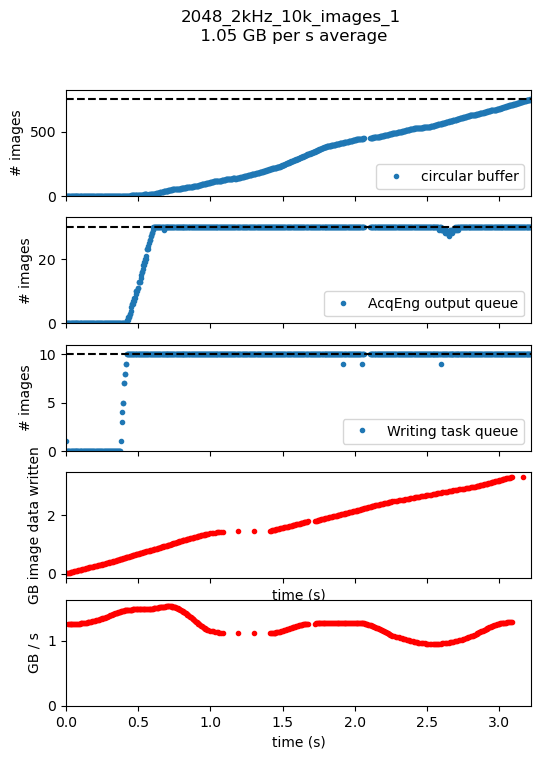

In [32]:
folder = "C:/Users/henry/Desktop/data/"

rates = []

for file in [
        '128_8kHz_64k_images_1',  
        '1024_1kHz_10k_images_1',
        '1024_2kHz_10k_images_1',
        '1024_8kHz_24k_images_1',
        '1536_1kHz_24k_images_1',
        '2048_1kHz_24k_images_1',
        '2048_2kHz_10k_images_1',        
]:

    circ_buffer_max, acq_queue_max, writing_queue_max, \
        time_ms, buffer_mem, acq_queue, writing_queue, \
        image_times_ms, bytes_written  = parse_data(folder + file )

    
    gb_per_s = make_queue_and_data_plots(circ_buffer_max, acq_queue_max, writing_queue_max, \
        time_ms, buffer_mem, acq_queue, writing_queue, image_times_ms, bytes_written,
                    smooth_rate_sigma=20, 
                                         # time_limits=[0, 5]
                                        )
    
    average_gb_per_s = bytes_written[-1] / 1024. ** 3 / ((image_times_ms[-1] - image_times_ms[0]) / 1000.)
                              # smooth based on actual time
                    # smooth_rate_sigma=100 / np.mean(image_times_ms[1:] - image_times_ms[:-1]))
    plt.gcf().suptitle(file + '\n {:.2f} GB per s average'.format(average_gb_per_s))
    rates.append(gb_per_s)
    
    
# sizes = np.array([512, 1024, 2048, 4096, 8192])
# speeds = [np.mean(r) for r in rates]
# err = [np.std(r) for r in rates]

# plt.figure()
# plt.gcf().suptitle('Average speed vs image size')
# plt.errorbar(sizes, speeds, err, fmt='ko-')
# plt.xlabel('Image dimension (pixels)')
# plt.ylabel('Average write speed (GB/s)')
# plt.ylim([0, np.max(speeds) *1.5])

(0.0, 1.0483787966577214)

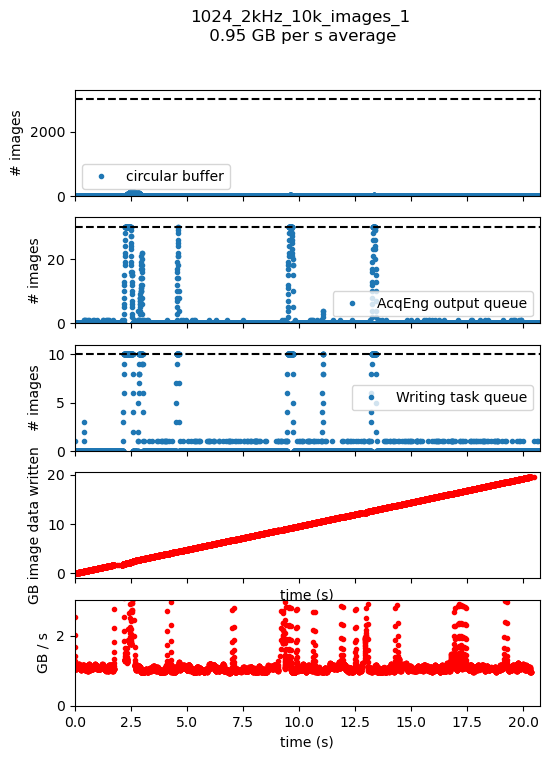

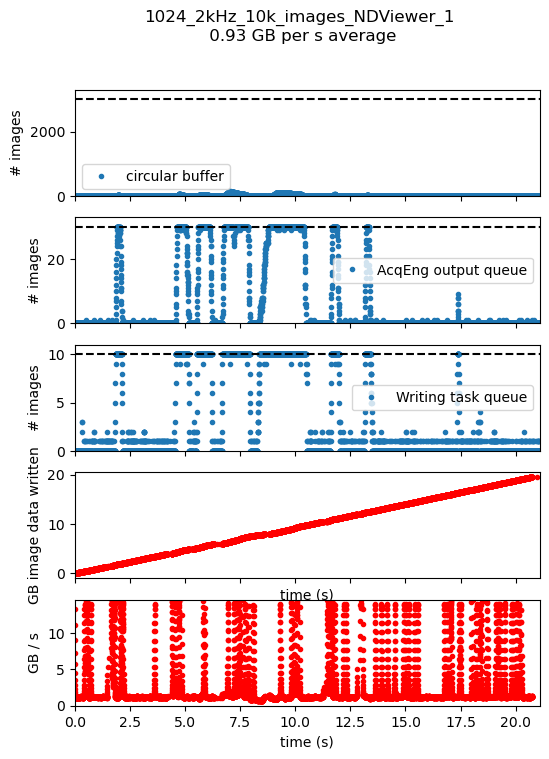

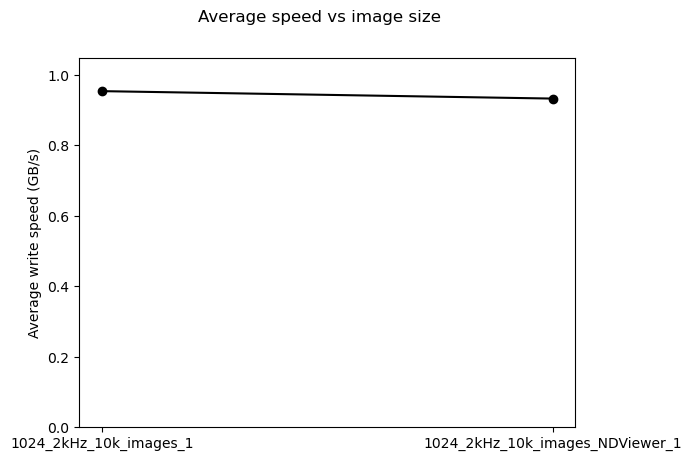

In [42]:
folder = "C:/Users/henry/Desktop/data/"
rates = []

files =  [
        '1024_2kHz_10k_images_1',
        '1024_2kHz_10k_images_NDViewer_1'
             ]

for file in files:
    circ_buffer_max, acq_queue_max, writing_queue_max, \
        time_ms, buffer_mem, acq_queue, writing_queue, \
        image_times_ms, bytes_written  = parse_data(folder + file )

    make_queue_and_data_plots(circ_buffer_max, acq_queue_max, writing_queue_max, \
        time_ms, buffer_mem, acq_queue, writing_queue, image_times_ms, bytes_written,
                             smooth_rate_sigma=6)
    average_gb_per_s = bytes_written[-1] / 1024. ** 3 / ((image_times_ms[-1] - image_times_ms[0]) / 1000.)
    rates.append(average_gb_per_s)

    plt.gcf().suptitle(file + '\n {:.2f} GB per s average'.format(average_gb_per_s))
    

plt.figure()
plt.gcf().suptitle('Average speed vs image size')
plt.plot(range(len(rates)), rates, 'ko-')
plt.xticks(ticks=range(len(files)),labels=files)
plt.ylabel('Average write speed (GB/s)')
plt.ylim([0, np.max(rates) *1.1])